In [1]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications

# dimensions of our images.
img_width, img_height = 300, 200

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = 'eye_2/train'
validation_data_dir = 'eye_2/validate'
nb_train_samples = 2368
nb_validation_samples = 800
epochs = 20
batch_size = 16


def save_bottlebeck_features():
    datagen = ImageDataGenerator(rescale=1.)

    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_train = model.predict_generator(
        generator, nb_train_samples // batch_size)
    np.save(open('bottleneck_features_train.npy', 'wb'), bottleneck_features_train)

    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_validation = model.predict_generator(
        generator, nb_validation_samples // batch_size)
    np.save(open('bottleneck_features_validation.npy', 'wb'), bottleneck_features_validation)


Using TensorFlow backend.


In [2]:
save_bottlebeck_features()

Found 2368 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [11]:
# nb_train_samples = 1992
# nb_validation_samples = 396

def train_top_model():
    train_data = np.load(open('bottleneck_features_train.npy', 'rb'))
    train_labels = np.array([0] * int(nb_train_samples/2) + [1] * int(nb_train_samples/2))

    validation_data = np.load(open('bottleneck_features_validation.npy', 'rb'))
    validation_labels = np.array([0] * 403 + [1] * 397)

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='Adam',
                  loss='binary_crossentropy', metrics=['accuracy'])

    model.fit(train_data, train_labels,
              epochs=20,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels))
    model.save_weights(top_model_weights_path)
    return model

In [12]:
m = train_top_model()

Train on 2368 samples, validate on 800 samples
Epoch 1/20
2368/2368 [==============================] - 7s - loss: 7.9824 - acc: 0.4987 - val_loss: 8.0310 - val_acc: 0.4963

In [5]:
validation_data = np.load(open('bottleneck_features_validation.npy', 'rb'))
validation_labels = np.array([0] * 403 + [1] * 397)
train_labels = np.array([0] * int(nb_train_samples/2) + [1] * int(nb_train_samples/2))
train_data = np.load(open('bottleneck_features_train.npy', 'rb'))


y_prob = m.predict_on_batch(validation_data)
y_pred = [int(x > 0.5) for x in y_prob]

y_train_prob = m.predict_on_batch(train_data)
y_train_pred = [int(x > 0.5) for x in y_train_prob]

In [6]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score
import itertools
import matplotlib.pyplot as plt


### plot confusion matrix
def plot_confusion_matrix(cm, title, ax):

    classes = ['0', '1']#, '2', '3', '4']

    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)
    
    ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title(title)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, '%.2f' %cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.grid(False)

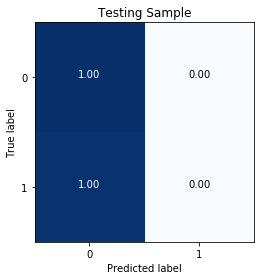

In [7]:
fig, ax = plt.subplots(1,1)
plot_confusion_matrix(confusion_matrix(validation_labels, y_pred), 'Testing Sample', ax)
plt.tight_layout()
plt.show()

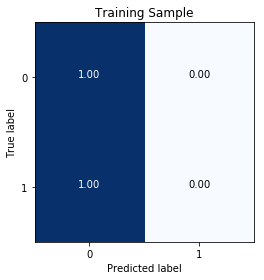

In [8]:
fig, ax = plt.subplots(1,1)
plot_confusion_matrix(confusion_matrix(train_labels, y_train_pred), 'Training Sample', ax)
plt.tight_layout()
plt.show()

In [37]:
for i in range(len(validation_labels)):
    if(validation_labels[i] != y_pred[i]):
        print(i, validation_labels[i], y_prob[i])


28 0 [ 1.]
161 0 [ 1.]
168 0 [ 1.]
192 0 [ 1.]
193 0 [ 1.]
195 0 [ 1.]
204 1 [  4.81394380e-25]
212 1 [ 0.]
217 1 [  1.15587817e-09]
240 1 [ 0.]
241 1 [ 0.]
277 1 [ 0.]
289 1 [ 0.]
291 1 [ 0.]
294 1 [ 0.]
307 1 [  3.58366160e-05]
337 1 [  3.94131117e-11]
345 1 [  9.89560372e-24]
348 1 [ 0.]
358 1 [ 0.]
367 1 [  2.21571071e-07]
371 1 [  1.24158897e-16]
374 1 [ 0.11515782]
391 1 [ 0.]
